In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc,os,sys

sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.3f}'.format

print(os.listdir("../input"))

['sample_submission.csv', 'test.csv', 'train.csv']


# Load data

In [2]:
%%time
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print(train.shape, test.shape)

(200000, 202) (200000, 201)
CPU times: user 14.3 s, sys: 1.15 s, total: 15.5 s
Wall time: 15.6 s


In [3]:
for c in train.columns:
    if c not in test.columns: print(c)

target


# Data analysis

In [4]:
null_cnt = train.isnull().sum().sort_values()
print('null count:', null_cnt[null_cnt > 0])

null count: Series([], dtype: int64)


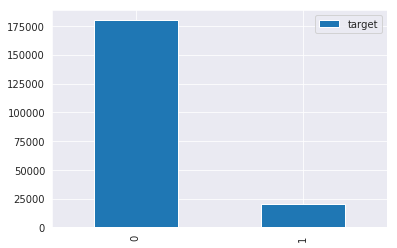

In [5]:
train['target'].value_counts().to_frame().plot.bar()

# Feature engineering

In [6]:
all_data = train.append(test, sort=False).reset_index(drop=True)
del train, test
gc.collect()

all_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0.000,8.925,-6.786,11.908,5.093,11.461,-9.283,5.119,18.627,-4.920,5.747,2.925,3.182,14.014,0.575,8.799,14.569,5.749,-7.239,4.284,30.713,10.535,16.219,2.579,2.472,14.383,13.432,-5.149,-0.407,4.931,5.997,-0.308,12.904,-3.877,16.891,11.192,10.579,0.676,7.887,...,15.458,5.313,3.616,5.038,6.676,12.664,2.700,-0.698,9.598,5.488,-4.764,-8.425,20.877,3.153,18.562,7.742,-10.124,13.724,-3.519,1.720,-8.405,9.016,3.066,14.369,25.840,5.876,11.841,-19.716,17.574,0.586,4.435,3.964,3.136,1.691,18.523,-2.398,7.878,8.563,12.780,-1.091
1,train_1,0.000,11.501,-4.147,13.859,5.389,12.362,7.043,5.621,16.534,3.147,8.085,-0.403,8.059,14.024,8.414,5.434,13.700,13.828,-15.585,7.800,28.571,3.429,2.741,8.552,3.372,6.978,13.891,-11.768,-2.559,5.046,0.548,-9.299,7.875,1.286,19.371,11.370,0.740,2.800,5.843,...,29.485,5.868,3.821,15.835,-5.012,15.134,3.200,9.319,3.882,5.800,5.538,5.099,22.033,5.513,30.265,10.497,-7.235,16.572,-7.348,11.075,-5.594,9.488,-14.910,9.425,22.544,-4.862,7.654,-15.932,13.318,-0.357,7.642,7.721,2.584,10.952,15.431,2.034,8.127,8.789,18.356,1.952
2,train_2,0.000,8.609,-2.746,12.081,7.893,10.582,-9.084,6.943,14.616,-4.919,5.952,-0.325,-11.265,14.193,7.312,7.524,14.647,7.678,-1.740,4.701,20.477,17.756,18.138,1.214,3.514,5.678,13.218,-7.994,-2.903,5.846,6.144,-11.102,12.486,-2.287,19.042,11.045,4.109,4.697,6.935,...,13.207,5.844,4.709,5.714,-1.041,20.509,3.279,-5.595,7.318,5.769,-7.093,-3.912,7.257,-5.823,25.682,10.920,-0.310,8.844,-9.701,2.401,-4.293,9.391,-13.265,3.155,23.087,-5.300,5.375,-6.266,10.193,-0.842,2.906,9.790,1.670,1.686,21.604,3.142,-6.521,8.268,14.722,0.397
3,train_3,0.000,11.060,-2.152,8.952,7.196,12.585,-1.836,5.843,14.925,-5.861,8.245,2.306,2.810,13.846,11.970,6.457,14.837,10.743,-0.430,15.943,13.726,20.301,12.558,6.820,2.723,12.135,13.737,0.814,-0.906,5.907,2.841,-15.240,10.441,-2.573,6.180,10.609,-5.916,8.172,2.852,...,31.883,5.968,7.208,3.890,-11.088,17.250,2.588,-2.702,0.564,5.343,-7.154,-6.192,18.237,11.713,14.748,8.101,11.877,13.955,-10.470,5.696,-3.755,8.412,1.899,7.260,-0.464,-0.050,7.934,-12.828,12.412,1.849,4.467,4.743,0.718,1.421,23.035,-1.271,-2.928,10.292,17.970,-9.000
4,train_4,0.000,9.837,-1.483,12.875,6.638,12.277,2.449,5.941,19.251,6.265,7.678,-9.446,-12.142,13.848,7.889,7.789,15.055,8.487,-3.068,6.526,11.315,21.425,18.961,10.110,2.714,14.208,13.543,3.174,-3.342,5.902,7.935,-3.158,9.467,-0.008,19.324,12.406,0.633,2.792,5.818,...,33.511,5.695,5.466,18.220,6.577,21.261,3.230,-1.776,3.128,5.552,1.449,-2.663,19.806,2.370,18.468,16.331,-3.346,13.526,1.719,5.174,-7.694,9.768,4.891,12.220,11.850,-7.893,6.421,5.927,16.020,-0.283,-1.490,9.521,-0.151,9.194,13.288,-1.512,3.927,9.503,17.997,-8.810


## Preparation

In [7]:
from sklearn import preprocessing

features = [c for c in all_data.columns if c not in ['target', 'ID_code']]
for feat in features:
    #all_data[feat+'_var'] = all_data.groupby([feat])[feat].transform('var')
    all_data[feat+'_var'] = all_data[feat].var()
    all_data[feat+'_plus'] = all_data[feat] + all_data[feat+'_var']
    all_data[feat+'_minus'] = all_data[feat] - all_data[feat+'_var']
    all_data.loc[:,[feat+'_plus', feat+'_minus']].fillna(0, inplace=True)
    all_data.drop([feat+'_var'], axis=1, inplace=True)

scaler = preprocessing.StandardScaler()
numcols = all_data.drop('target',axis=1).select_dtypes(include='number').columns.values
all_data.loc[:,numcols] = scaler.fit_transform(all_data[numcols])
#all_data.loc[:,features] = scaler.fit_transform(all_data[features])

In [8]:
X_train = all_data[all_data['target'].notnull()].reset_index(drop=True)
X_test = all_data[all_data['target'].isnull()].drop(['target'], axis=1).reset_index(drop=True)
del all_data
gc.collect()

# drop ID_code
X_train.drop(['ID_code'], axis=1, inplace=True)
X_test_ID = X_test.pop('ID_code')

Y_train = X_train.pop('target')

print(X_train.shape, X_test.shape)

(200000, 600) (200000, 600)


## GaussianNB

In [9]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB

folds = StratifiedKFold(n_splits=10)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train)):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]

    model = GaussianNB()
    model.fit(trn_x, trn_y)

    oof_preds[val_] = model.predict_proba(val_x)[:,1]
    sub_preds += model.predict_proba(X_test)[:,1] / folds.n_splits

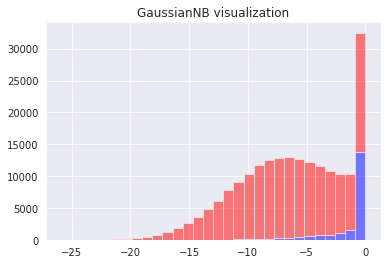

In [10]:
gnb_1 = oof_preds[Y_train > 0]
gnb_0 = oof_preds[Y_train == 0]
plt.hist([np.log(gnb_1), np.log(gnb_0)], color=['b','r'], bins=30, alpha=0.5, histtype='barstacked')
plt.title('GaussianNB visualization')
plt.show()

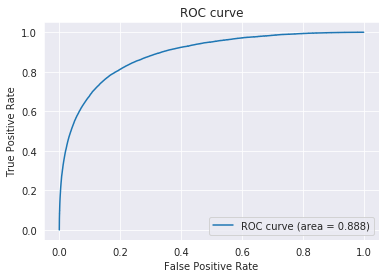

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(Y_train, oof_preds)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [12]:
preds = sub_preds

# Submit

In [13]:
submission = pd.DataFrame({
    'ID_code': X_test_ID,
    'target': preds
})
submission.to_csv("submission.csv", index=False)

In [14]:
submission['target'].sum()

30720.85488070479

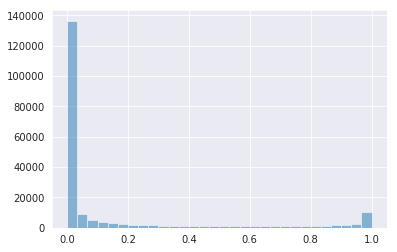

In [15]:
submission['target'].hist(bins=30, alpha=0.5)
plt.show()